In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
from datetime import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
import csv

from functions import return_date,change_date,return_time_diff,fix_missing_date

In [2]:
# Get the current working directory and append "data/"
data_dir = os.path.join(os.getcwd(), "data/")

# Initialize an empty list using list comprehension
files = [file for file in os.listdir(data_dir) if file.endswith(".LOG")]

# Loop through the files and print their names
for file in files:
    print(file)

TSENSOR_DKB.LOG
TSENSOR_LG.LOG
TSENSOR_kmroz_fixed.LOG
TSENSOR_cleaned.LOG
TSENSOR_QR.LOG
TSENSOR_DF.LOG
TSENSOR_SimonS.LOG
TSENSOR_6_KS.LOG


In [3]:
# Specify the path to the directory containing the data files
path = "data/"

# Create an empty list to store the dataframes
dfs = []

# Loop through the files in the directory
for file in os.listdir(path):
    # Check if the file is a LOG file
    if file.endswith(".LOG"):
        # Read the CSV file into a dataframe
        new_df = pd.read_csv(os.path.join(path, file), 
                             delimiter=r"[,\s]+", 
                             comment="#", 
                             names=["date", "millis", "sensor_id", "spot_meas"], 
                             engine="python")
        # Append the dataframe to the list of dataframes
        dfs.append(new_df)

# Concatenate all the dataframes into a single dataframe
df = pd.concat(dfs, ignore_index=True)

In [4]:
df['date'] = df.apply(change_date, axis=1)

In [5]:
ids = pd.unique(df["sensor_id"])

In [6]:
def find_trigger_time(df):
    trigg = df[df["spot_meas"].diff() < -2.3].iloc[0]["date"]
    return trigg

def adjust_timestamp(trig_time,ID,df):
    mask = df["sensor_id"] == ID
    df_trig_time = find_trigger_time(df[df["sensor_id"] == ID])
    diff_time = trig_time - df_trig_time
    df.loc[mask, "date"] = df.loc[mask, "date"] + diff_time

Triggered else for ID: 61ac96f013c
Triggered else for ID: 50c596f013c


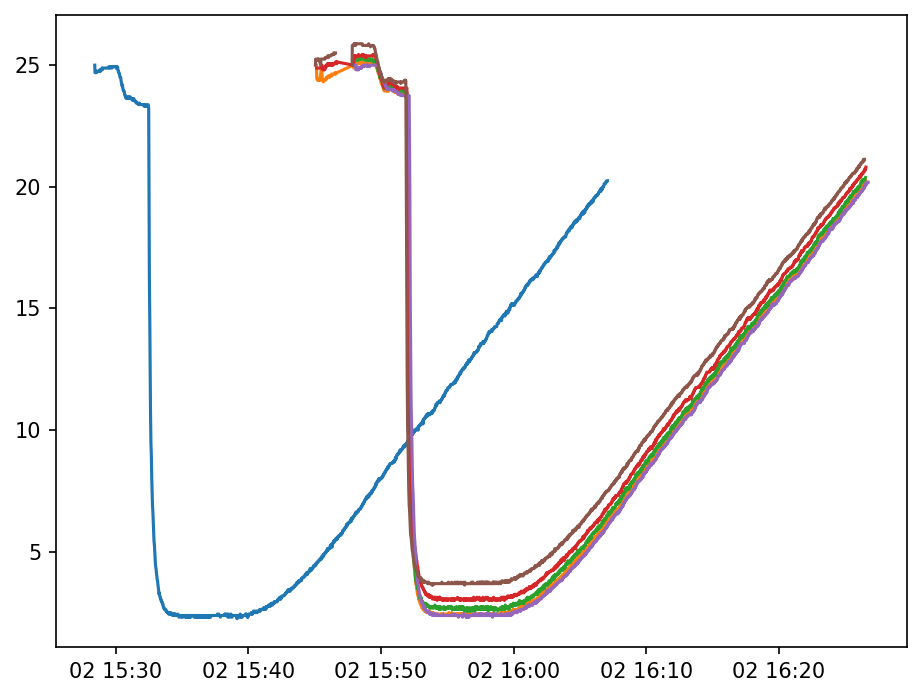

In [7]:
fig, ax = plt.subplots(nrows=1
                         ,ncols=1
                         ,figsize=(6.4,4.8)
                         ,dpi = 150
                        )
fig.tight_layout()

dfs = []
trigger_time = datetime.strptime("2023-03-02 15:51:59",'%Y-%m-%d %H:%M:%S')

for i in ids:
    if len(df[df["sensor_id" ] == i]["date"].unique()) > 1:
        plt.plot(df[df["sensor_id"]== i]["date"],df[df["sensor_id"] == i]["spot_meas"])
        adjust_timestamp(trigger_time,i,df)
        dfs.append(df[df["sensor_id" ] == i].pivot(index="date", columns="sensor_id", values="spot_meas"))
    else:
        print("Triggered else for ID: "+ i)
        mask = df["sensor_id"] == i
        df.loc[mask, "date"] = df.loc[mask].apply(fix_missing_date, axis=1)
        adjust_timestamp(trigger_time,i,df)
        dfs.append(df[df["sensor_id" ] == i].pivot(index="date", columns="sensor_id", values="spot_meas"))
        
plt.savefig("plots/plot1.pdf")

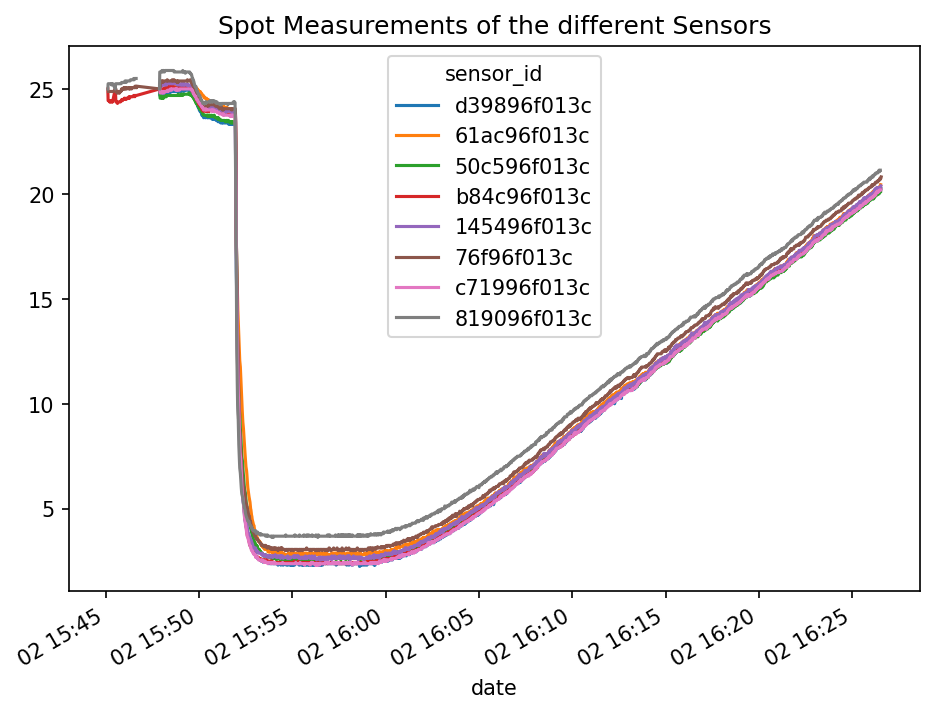

In [8]:
fig, ax = plt.subplots(nrows=1
                         ,ncols=1
                         ,figsize=(6.4,4.8)
                         ,dpi = 150
                        )
#fig.suptitle('Data From from the different Sensors', fontsize=13)
fig.tight_layout()
ax.set_title('Spot Measurements of the different Sensors')
for i_df in dfs:
    i_df.plot(ax=ax)
    
plt.savefig("plots/plot2.pdf")

In [9]:
# Read the first CSV file into a Pandas DataFrame with the following settings:
cal_df = pd.read_csv(os.path.join("data/cal/", "tsensor_calibration_time_constant_new.log"), 
                     delimiter=r"[,\s]+",  # Delimiter can be either comma or whitespace
                     comment="#",  # Ignore lines starting with #
                     names=["date", "spot_meas"],  # Set column names
                     engine="python")  # Use the Python engine to read the CSV file

# Read the second CSV file into another DataFrame with the same settings:
cal_df2 = pd.read_csv(os.path.join("data/cal/", "tsensor_calibration2.log"), 
                      delimiter=r"[,\s]+", 
                      comment="#", 
                      names=["date", "spot_meas"], 
                      engine="python")

# Prepend the date string "2023-03-02 " to the "date" column in both DataFrames:
cal_df["date"] = "2023-03-02 " + cal_df["date"]
cal_df2["date"] = "2023-03-02 " + cal_df2["date"]

# Apply the "change_date" function to the "date" column in both DataFrames:
cal_df['date'] = cal_df.apply(change_date, axis=1)
cal_df2['date'] = cal_df2.apply(change_date, axis=1)

# Concatenate both DataFrames into a single DataFrame:
cal_df = pd.concat([cal_df, cal_df2], ignore_index=True)

# Set the "date" column as the index of the DataFrame:
cal_df.set_index('date', inplace=True)


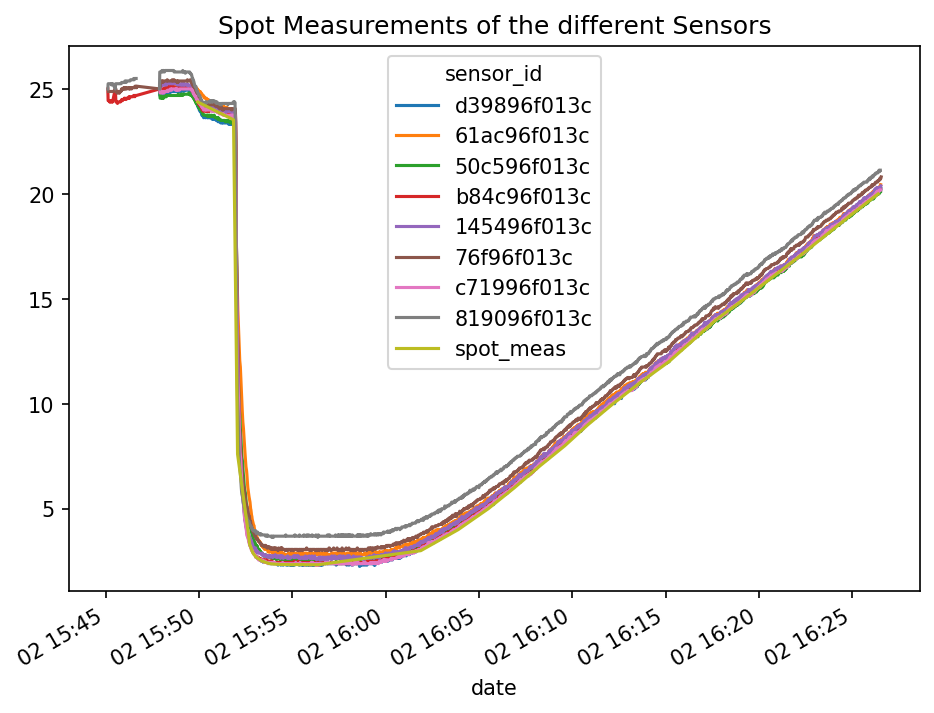

In [10]:

fig, ax = plt.subplots(nrows=1
                         ,ncols=1
                         ,figsize=(6.4,4.8)
                         ,dpi = 150
                        )
#fig.suptitle('Data From from the different Sensors', fontsize=13)
fig.tight_layout()
ax.set_title('Spot Measurements of the different Sensors')
for i_df in dfs:
    i_df.plot(ax=ax)
 
cal_df.plot(ax=ax)

plt.savefig("plots/plot3.pdf")


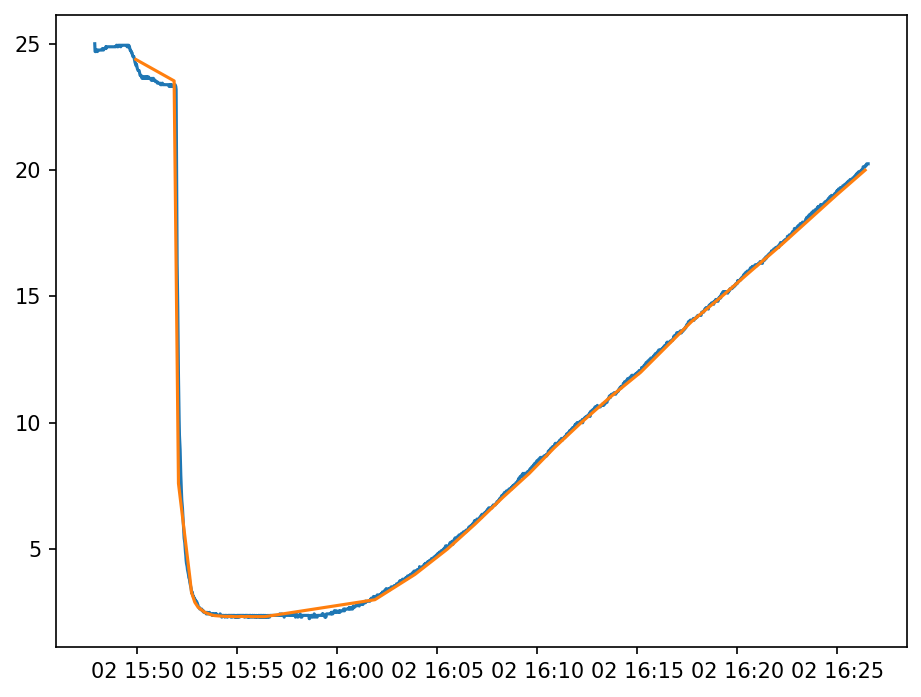

In [11]:
fig, ax = plt.subplots(nrows=1
                         ,ncols=1
                         ,figsize=(6.4,4.8)
                         ,dpi = 150
                        )
#fig.suptitle('Data From from the different Sensors', fontsize=13)
fig.tight_layout()

plt.plot(dfs[0]["d39896f013c"].index,dfs[0]["d39896f013c"].values)
plt.plot(cal_df.index,cal_df.values)

In [12]:
cal_df.loc["2023-03-02 15:55:03"][0]

2.33

In [13]:
for i, i_df in enumerate(dfs): # changed i_df to df to follow standard naming convention for dataframes
    # calculate the difference between the value at the specified time in the current dataframe and the calibration dataframe
    diff = round(i_df.loc["2023-03-02 15:55:01"][0] - cal_df.loc["2023-03-02 15:55:03"][0], 2)
    
    # print the values and difference for debugging purposes
    print(i_df.loc["2023-03-02 15:55:01"][0], " - ", cal_df.loc["2023-03-02 15:55:03"][0], " = ", diff)
    
    # subtract the difference from all values in the current dataframe to adjust for calibration
    dfs[i] = i_df - diff


2.38  -  2.33  =  0.05
2.88  -  2.33  =  0.55
2.63  -  2.33  =  0.3
2.44  -  2.33  =  0.11
2.69  -  2.33  =  0.36
3.06  -  2.33  =  0.73
2.38  -  2.33  =  0.05
3.69  -  2.33  =  1.36


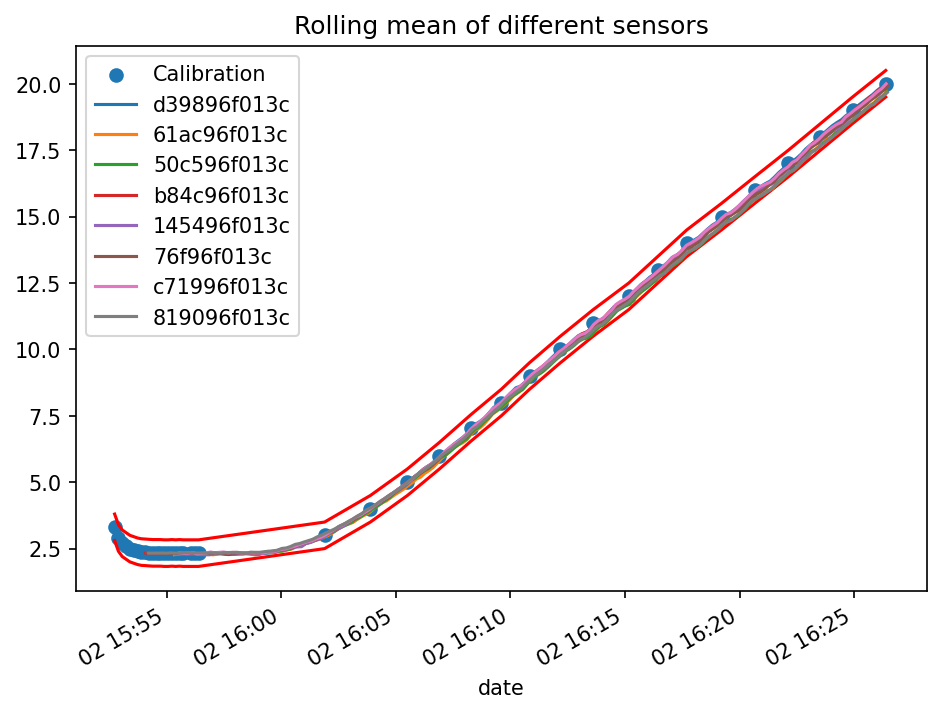

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.4, 4.8), dpi=150)

fig.tight_layout()
ax.set_title('Rolling mean of different sensors')
ax.scatter(x=cal_df.index[4::], y=cal_df.values[4::], label='Calibration')
ax.plot(cal_df.index[4::],cal_df.values[4::]+0.5,color = "red")
ax.plot(cal_df.index[4::],cal_df.values[4::]-0.5,color = "red")

for i_df in dfs:
    # Take the rolling mean of the df (mean of the 10 values before) and then print only every tenth value -> avg_meas
    i_df.rolling(10).mean().iloc[400::10].plot(ax=ax)

ax.legend()
plt.savefig("plots/plot5.pdf")


Time a sensor needs to adapt its output signal to 63.2% of a change in measured quantity

In [26]:
# Get the index of the rows in the dataframe where the "date" column is equal to the "trigger_time"
start_idx = df[df["date"] == trigger_time].index

# Add 50 to the start index to get the end index
end_idx = start_idx + 50

dfs2 = []

timedel = []
# Loop over the ids and corresponding start and end indices
for idx, i in enumerate(ids):
    # Get the spot_meas value at the start and end indices
    start = df.iloc[start_idx[idx]]["spot_meas"]
    end = df.iloc[end_idx[idx]]["spot_meas"]
    
    # Calculate the cut off value using the start and end values
    cut_off = start - 0.632 * (start - end)
    c = 0
    
    # Print the cutoff value for the current id
    print(f"{i}: {cut_off}")
    
    # Loop through the rows from the start index until the cutoff value is reached
    while df.iloc[start_idx[idx] + c]["spot_meas"] > cut_off:
        c += 1
    
    # Print the cutoff value, time delta, and a separator
    print(f"Cut off: {df.iloc[start_idx[idx]+c]['spot_meas']}")
    time_delta = (df.iloc[start_idx[idx]+c]["date"] - df.iloc[start_idx[idx]]["date"]).seconds
    print(f"Time: {time_delta}")
    print("-----------")
    
    # Append the time delta to a list
    timedel.append(time_delta)


d39896f013c: 8.66608
Cut off: 8.38
Time: 11
-----------
61ac96f013c: 10.09384
Cut off: 10.0
Time: 19
-----------
50c596f013c: 9.572
Cut off: 9.5
Time: 12
-----------
b84c96f013c: 9.319999999999999
Cut off: 9.06
Time: 11
-----------
145496f013c: 9.636239999999999
Cut off: 9.0
Time: 10
-----------
76f96f013c: 9.698
Cut off: 9.31
Time: 8
-----------
c71996f013c: 9.15808
Cut off: 9.06
Time: 10
-----------
819096f013c: 9.39008
Cut off: 9.38
Time: 7
-----------


In [27]:
print("Average Time constant: ",sum(timedel)/8)

Average Time constant:  11.0


$u_{time\_delta} = \sqrt{1^2+(-1)^2)} = \sqrt{2}$

$u_{avg_time} = \sqrt{(1/8*\sqrt{2})^2} = \sqrt{1/32} = 4\sqrt{0.5} ≈ 2.82843$